In [1]:
from attention import AttentionLayer

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("Reviews.csv",nrows=50000)

# Drop Duplicates and NA values

In [4]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

# Information about dataset

Let us look at datatypes and shape of the dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46248 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      46248 non-null  int64 
 1   ProductId               46248 non-null  object
 2   UserId                  46248 non-null  object
 3   ProfileName             46248 non-null  object
 4   HelpfulnessNumerator    46248 non-null  int64 
 5   HelpfulnessDenominator  46248 non-null  int64 
 6   Score                   46248 non-null  int64 
 7   Time                    46248 non-null  int64 
 8   Summary                 46248 non-null  object
 9   Text                    46248 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.9+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [7]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [8]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [9]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [10]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [12]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [13]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

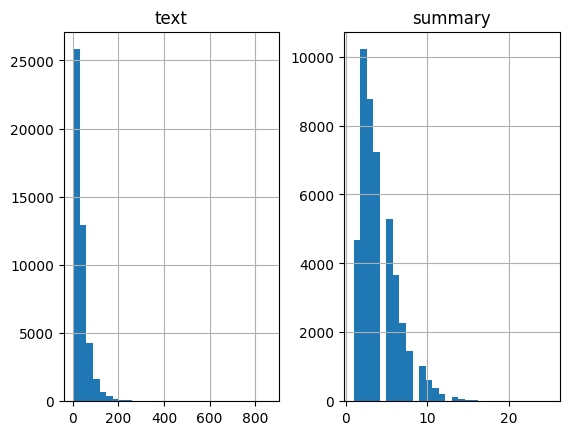

In [14]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [15]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9439298853062108


In [16]:
max_text_len=30
max_summary_len=8

In [17]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [18]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [19]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [20]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [21]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.14447827290341
Total Coverage of rare words: 4.073003482411864


In [22]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [23]:
x_voc

6117

In [24]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [25]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.92803504380475
Total Coverage of rare words: 7.3059708438036735


In [26]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [27]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(22597, 22597)

In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [30]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              611700    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 30, 300),            481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [33]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
171/171 [==============================] - 269s 1s/step - loss: 3.0248 - val_loss: 2.5451
Epoch 2/5
171/171 [==============================] - 286s 2s/step - loss: 2.6168 - val_loss: 2.4895
Epoch 3/5
171/171 [==============================] - 283s 2s/step - loss: 2.5476 - val_loss: 2.4352
Epoch 4/5
171/171 [==============================] - 288s 2s/step - loss: 2.4879 - val_loss: 2.3828
Epoch 5/5
171/171 [==============================] - 293s 2s/step - loss: 2.4243 - val_loss: 2.3380


#Understanding the Diagnostic plot

Now, we will plot a few diagnostic plots to understand the behavior of the model over time:

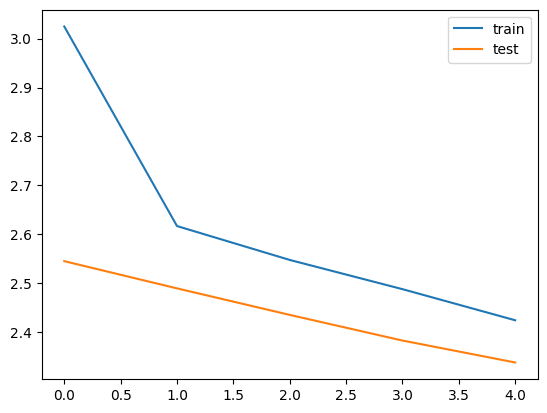

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [35]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [36]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [37]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [38]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [39]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: part problem really eat maybe later thins quite thin would prefer make good snack top anything moist time get soggy pretty fast 
Original summary: you cannot eat just one 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  great product


Review: topping used local al theater chain love seen topping could find source great stuff delivery quick suprised thanks offering consumer 
Original summary: theater grade 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  great


Review: first time italy wife actually give gifts well good sucks seasonal definitely makes look forward holidays 
Original summary: better than crack 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  great


Review: tea tasty love night little soy milk splenda would recommend people trying healthy green tea 
Original summary: yummy 
1/1 [==============================] - 0s 18ms/step
Predicted summary:  great tea


Review: bought brand better ever b

1/1 [==============================] - 0s 33ms/step
Predicted summary:  great product


Review: stuff great brown sugar flavor best easy make since make microwave quickly even kids great quick easy healthy yummy breakfast satisfied product 
Original summary: very yummy oatmeal 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  great


Review: also die hard folgers coffee fan simply prefer brand others said reviews cans oddly small wish lbs cans buy dollar general much smaller therefore amazon deal 
Original summary: love folgers not the best deal around 
1/1 [==============================] - 0s 25ms/step
Predicted summary:  great coffee


Review: bought gift boyfriend dogs looked really cute package left dogs gassy german shepard fairly large sizes little rough tummy use lightly 
Original summary: cute idea 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  dogs dogs dogs


Review: found sauce freshest good home made sauce winner book go fis

1/1 [==============================] - 0s 22ms/step
Predicted summary:  great


Review: coffee great buy though local grocery store much less local sam club less 
Original summary: do not buy it here 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  great coffee


Review: using bread mix months love husband actually likes better regular bread simply put bread machine comes perfect know would without amazon best price found 
Original summary: your is over 
1/1 [==============================] - 0s 36ms/step
Predicted summary:  great


Review: cookies small grainy crunchy awful aftertaste expensive small package cookies might great multiple allergies disappointed 
Original summary: not that great 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  great


Review: one many companies sneak foul tasting sugar products rip customers zero stars one amazon 
Original summary: with 
1/1 [==============================] - 0s 32ms/step
Predicted summary:

1/1 [==============================] - 0s 33ms/step
Predicted summary:  great product


Review: drink completely taste buds feeling bliss fruit drink tasted like freshly picked exotic country blended perfection carbonation delightful 
Original summary: tasty and 
1/1 [==============================] - 0s 33ms/step
Predicted summary:  great


Review: favorite kitchens india product others said lacking cottage cheese cashews delicious nevertheless going eat rice indian rice obviously best eaten instant brown rice cooked chicken broth came surprisingly good 
Original summary: flavorful quick tasty 
1/1 [==============================] - 0s 51ms/step
Predicted summary:  great


Review: worse bbq ever tasted bought saw man food show stomach tasting thin sauce bought wow texas really know bbq sauce 
Original summary: juice 
1/1 [==============================] - 0s 41ms/step
Predicted summary:  great


Review: product received product pictured product received variety juniper bonsai style th

1/1 [==============================] - 0s 41ms/step
Predicted summary:  great


Review: odor free fact stink bully sticks past would 
Original summary: not free 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  great


Review: although price great decaffeinated keurig cups properly sealed caused coffee brewed 
Original summary: cups were not 
1/1 [==============================] - 0s 34ms/step
Predicted summary:  great


Review: cats live outdoor come every evening give treats get super excited every time give whiskas temptations brands keep brands avoid way gave slice ham hope helps 
Original summary: we love temptations 
1/1 [==============================] - 0s 30ms/step
Predicted summary:  my dogs loves these


Review: admit love tea put splenda taste wonderful probably went pack boxes year alone counting teas drink must try hot cold 
Original summary: french vanilla decaf 
1/1 [==============================] - 0s 23ms/step
Predicted summary:  great tea


Re